In [51]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn import preprocessing

from phate import PHATE

import matplotlib.pyplot as plt

import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import Predictive

import numpy as np

import matplotlib.pyplot as plt

import os

from src.models.TurbulenceNetwork import TurbulenceNetworkBayesian
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:88: RuntimeWarning: invalid value encountered in arccos
  


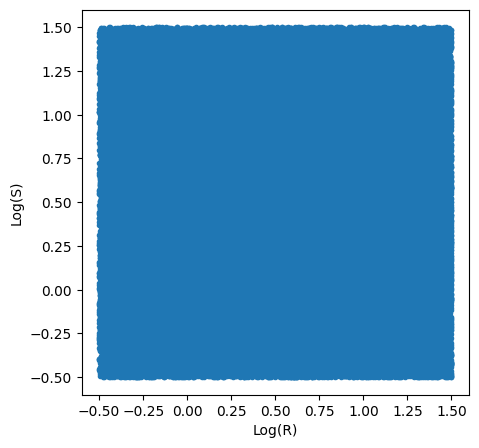

In [52]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 1.5)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 300, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Training Parameters

In [53]:
model_params = {
    "input_dim": 2,
    "output_dim": 3,
    "h_nodes": 20,
    "residual_blocks": 1,
    "layer_per_residual": 1,
    "data_size": etas_train.shape[0],
    "layer_prior": torch.tensor([0., 5.], device=device),
    "device": device,
    "output_prior": torch.tensor([.05], device=device)
}

In [54]:
model = TurbulenceNetworkBayesian(**model_params).to(device)

display(model)

guide = AutoDiagonalNormal(model)

adam = Adam({"lr": 0.001})
svi = SVI(model, guide, adam, loss=Trace_ELBO(num_particles=2))

TurbulenceNetworkBayesian(
  (stem): PyroLinear(in_features=2, out_features=20, bias=True)
  (layers): PyroModuleList(
    (0): BayesianLinearResidualBlock(
      (layers): PyroModuleList(
        (0): BayesianLinearResidual(
          (linear): PyroLinear(in_features=20, out_features=20, bias=True)
          (activation): ReLU()
        )
      )
    )
  )
  (output): PyroLinear(in_features=20, out_features=3, bias=True)
)

## Defining Datasets

In [55]:
x_scaler = preprocessing.StandardScaler().fit(etas_train)
y_scaler = preprocessing.StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=512, shuffle=True)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=torch.float32).to(device)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=torch.float32).to(device)

## SVI Training

In [60]:
#pyro.clear_param_store()

n_epochs = 1000

for epoch in range(n_epochs):
    loss = 0
    for bx_train, by_train in train_loader:
        bx_train = bx_train.to(device)
        by_train = by_train.to(device)
        loss += svi.step(bx_train, by_train)

    if epoch % 5 == 0:
        test_loss = svi.evaluate_loss(x_test, y_test)
        print(f"Epoch {epoch:8d} Test loss: {test_loss:20.4f}, Train loss: {loss:20.4f}")

Epoch        0 Test loss:          -86337.4524, Train loss:       -12150728.9500
Epoch        5 Test loss:          -62735.2457, Train loss:       -12980671.1017
Epoch       10 Test loss:          -88813.6723, Train loss:       -14473769.1515
Epoch       15 Test loss:          -89025.2330, Train loss:       -13112300.9970
Epoch       20 Test loss:          -62673.5966, Train loss:       -13582126.8510
Epoch       25 Test loss:          -82512.7449, Train loss:       -12574489.1403
Epoch       30 Test loss:          -89006.8148, Train loss:       -13456692.0385
Epoch       35 Test loss:          -90328.1962, Train loss:       -12864337.2329
Epoch       40 Test loss:          -92092.5195, Train loss:       -14745101.2187
Epoch       45 Test loss:          -86576.0278, Train loss:       -13320365.6298
Epoch       50 Test loss:          -90708.1755, Train loss:       -14169038.0794
Epoch       55 Test loss:          -93350.7037, Train loss:       -12073527.6930
Epoch       60 Test loss:   

KeyboardInterrupt: 

In [61]:
save_pyro_model(model, guide, "Model_Checkpoints", chkpt_name='pyro2')

## Loading Trained Model

In [56]:
model = TurbulenceNetworkBayesian(**model_params)

model, guide = load_pyro_model(model, "Model_Checkpoints", device, chkpt_name='pyro2')


model = model.to(device)
guide = guide.to(device)

tensor(0.2148, dtype=torch.float64)


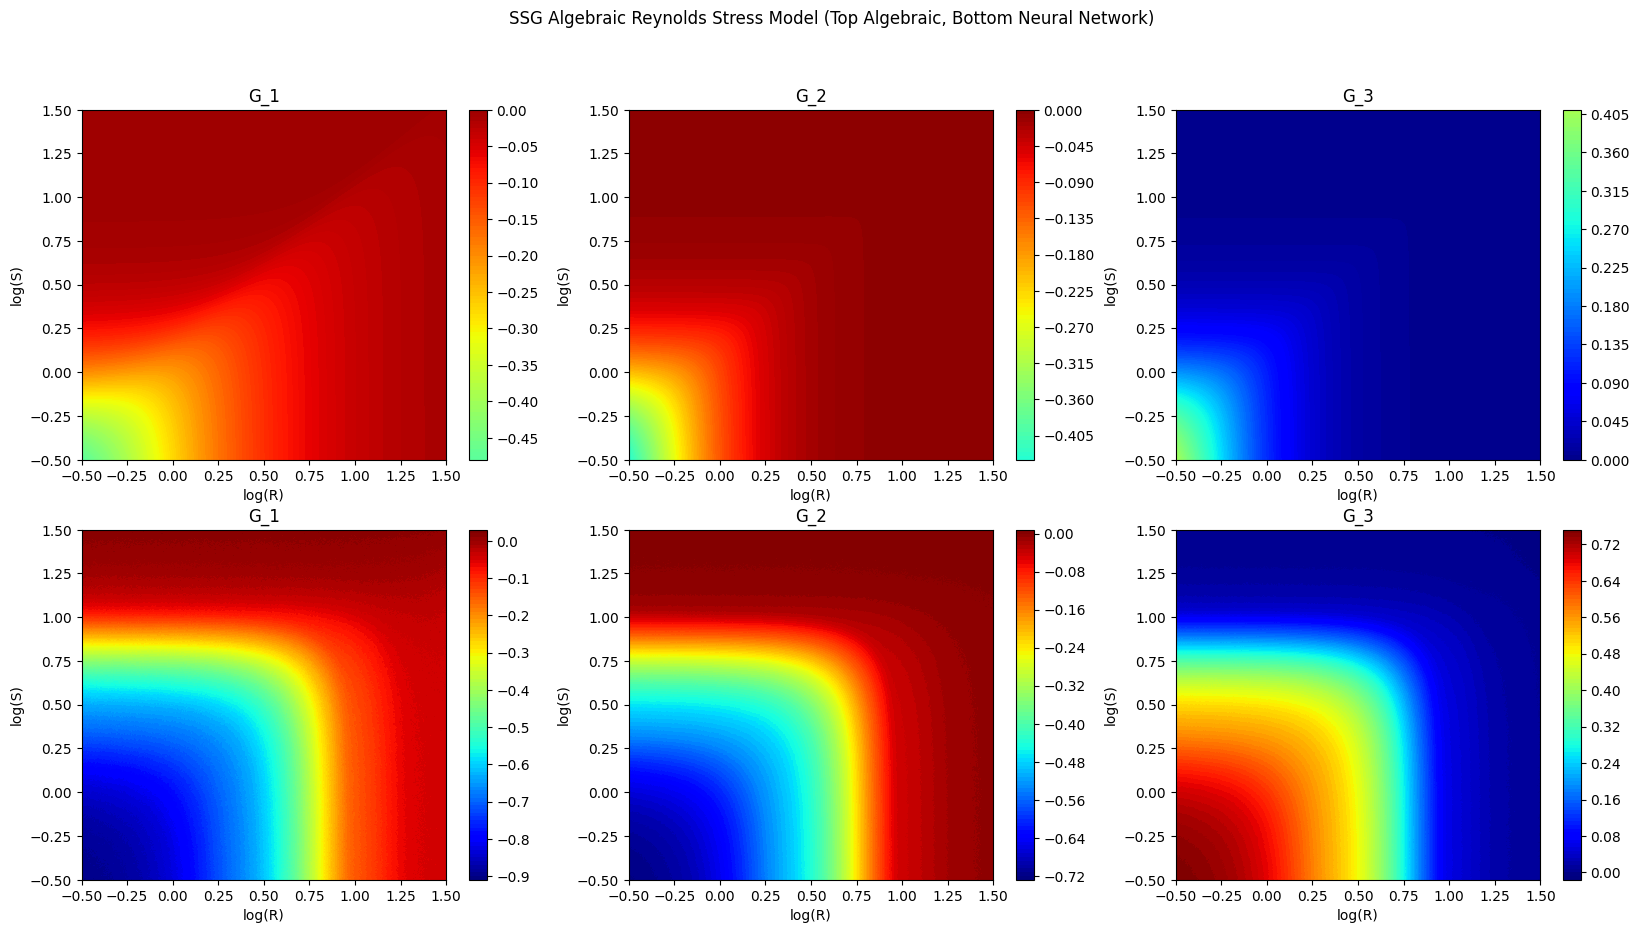

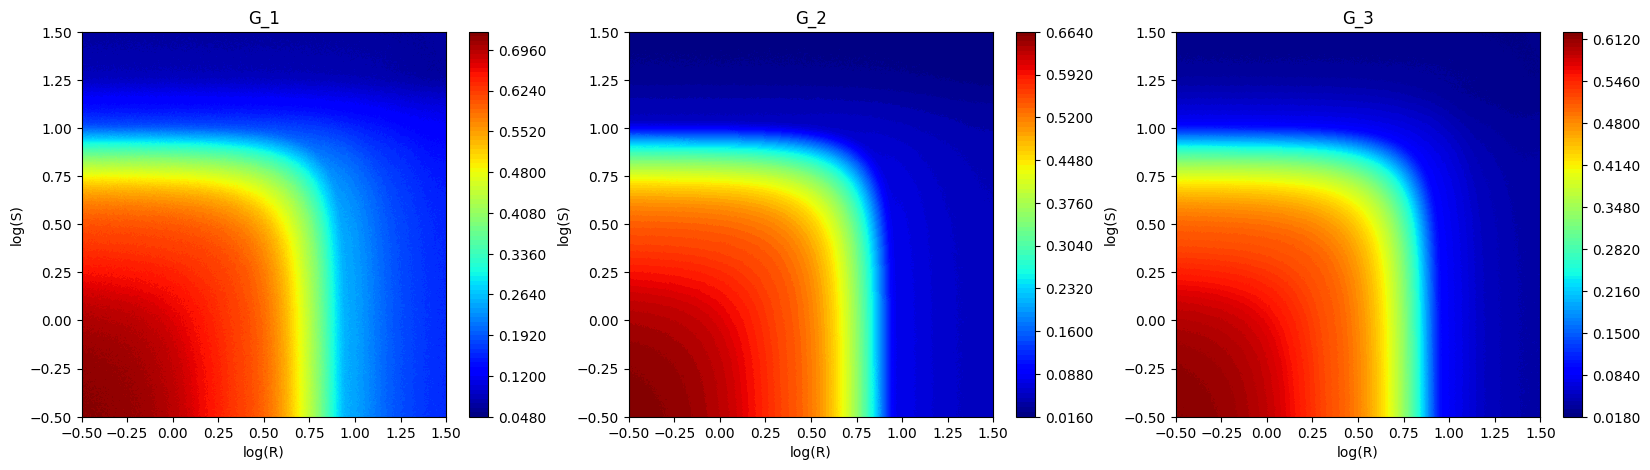

In [59]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

model.data_size = etas.shape[0]
etas = x_scaler.transform(etas)

predictive = Predictive(model, guide=guide, num_samples=100, return_sites=("obs",))

pred = predictive(torch.tensor(etas, dtype=torch.float32).to(device))['obs']

for i in range(pred.shape[0]):
    pred[i] = torch.tensor(y_scaler.inverse_transform(pred[i].cpu().detach().numpy())).to(device)

pred_mean = torch.mean(pred, axis=0).detach().cpu()
pred_std = torch.std(pred, axis=0).detach().cpu()

del pred
del predictive
torch.cuda.empty_cache()

print(torch.mean(torch.abs(torch.tensor(target) - pred_mean)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), pred_mean.T.reshape(3, dim, dim).numpy())

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim).numpy())

## Visualizing Functions

### Loading 2 different trainings and predicting

In [64]:
chkpt_names = ['pyro',"pyro2"]

predictions = []
labels = []

for i,chkpt in enumerate(chkpt_names):
    model = TurbulenceNetworkBayesian(**model_params)
    model, guide = load_pyro_model(model, "Model_Checkpoints", device, chkpt_name=chkpt)
    predictive = Predictive(model, guide=guide, num_samples=100, return_sites=("obs",))
    preds = predictive(x_test)['obs'].detach().cpu()
    preds = preds.reshape(preds.shape[0], -1)
    predictions.append(preds)
    labels.append(np.ones(preds.shape[0])*i)

predictions.append(y_test.cpu().flatten().unsqueeze(0))
labels.append([2])

test_outputs = torch.cat(predictions, dim=0)    
labels = np.concatenate(labels)

### Plotting Functions

Calculating PHATE...
  Running PHATE on 201 observations and 900 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.56 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
    Calculated affinities in 0.08 seconds.
  Calculated graph and diffusion operator in 0.67 seconds.
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.08 seconds.
Calculated PHATE in 0.80 seconds.


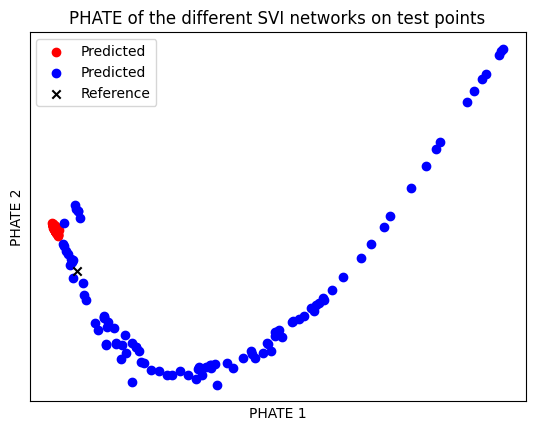

In [65]:
phate_op = PHATE(n_components=2)
phate_outputs = phate_op.fit_transform(test_outputs)


fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(phate_outputs[labels == 0, 0], phate_outputs[labels == 0, 1],label="Predicted", c='red', alpha=1, marker='o')

ax.scatter(phate_outputs[labels == 1, 0], phate_outputs[labels == 1, 1],label="Predicted", c='blue', alpha=1, marker='o')

ax.scatter(phate_outputs[labels == 2, 0], phate_outputs[labels == 2, 1],label="Reference", c='black', alpha=1, marker='x')

plt.title("PHATE of the different SVI networks on test points")
plt.xlabel("PHATE 1")
plt.ylabel("PHATE 2")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()
